In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.io as sio
from epipolar_utils import *

# Algorithme  des Huit Points
La matrice fondamentale est un outil crucial dans la vision par ordinateur pour estimer la géométrie projective entre deux images. Elle est calculée à partir de correspondances de points entre les images. Voici le processus de l'estimation de la matrice fondamentale à partir de correspondances de points :

1. Sélectionnez un ensemble de correspondances de points entre les deux images. Chaque paire de points doit être bien appariée.



In [2]:
im_set='../data/set1'

In [3]:
# Lire les données
im1 = cv2.imread(im_set+'/image1.jpg')
im2 = cv2.imread(im_set+'/image2.jpg')
points1 = get_data_from_txt_file(im_set+'/pt_2D_1.txt')
points2 = get_data_from_txt_file(im_set+'/pt_2D_2.txt')

In [4]:
print('Points de correspondance dans limage de gauche ', points1.shape)
print('Points de correspondance dans limage de droite ', points2.shape)

Points de correspondance dans limage de gauche  (37, 3)
Points de correspondance dans limage de droite  (37, 3)


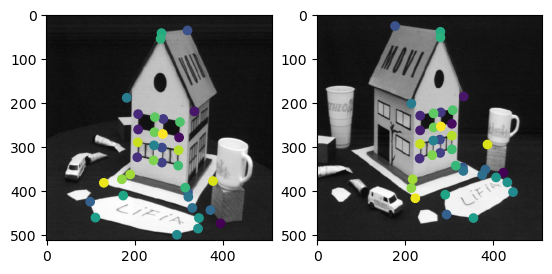

In [5]:
plt.subplot(121)
plt.imshow(im1)
plt.scatter(points1[:,0],points1[:,1],c=np.arange(len(points1)))
plt.subplot(122)
plt.imshow(im2)
plt.scatter(points2[:,0],points2[:,1],c=np.arange(len(points1)))

2. Formulez les équations de contrainte épipolaires. Pour deux points correspondants $p=(u_i,v_i,1)$ et $p'=(u'_i,v'_i,1)$ dans les images 1 et 2, respectivement, les équations de contrainte épipolaires sont données par :

$$
p'^T F p = 0
$$

où $F$ est la matrice fondamentale.

3. Rassemblez les équations de contrainte pour toutes les paires de points correspondants. Cela forme un système d'équations linéaires. En supposant que $n$ paires de points correspondent, le système peut être écrit sous forme matricielle comme :

$$
A \cdot f = 0
$$

où  






<img src="https://drive.google.com/uc?export=view&id=1LcXD_jK5xG5sX_idbcc7GzcX_YLGJZk2">

In [6]:
points_num = points2.shape[0]

A = np.zeros((points_num, 9))
for i in range(points_num):
        u1 = points1[i][0]
        v1 = points1[i][1]
        u2 = points2[i][0]
        v2 = points2[i][1]
        A[i] = np.array([u1*u2, u2*v1, u2, v2*u1, v1*v2, v2, u1, v1, 1])




4. Utilisez la méthode des moindres carrés pour résoudre le système $A \cdot f = 0$ et estimer $F$. Cela implique de décomposer la matrice $A$ et de trouver le vecteur propre correspondant à la plus petite valeur propre.



In [7]:
# calculer F_hat
U, s, VT = np.linalg.svd(A, full_matrices=True)
f = VT[-1, :]
F_hat = np.reshape(f, (3, 3))




5. Restauration de la contrainte de rang 2 : Utilisez la décomposition en valeurs singulières (SVD) pour décomposer la matrice fondamentale estimée en $F = UDV^T$. Mettez à zéro la plus petite valeur singulière dans $D$ et reformez $F = U\tilde{D}V^T$, où $\tilde{D}$ est la matrice diagonale avec les mêmes valeurs que $D$ sauf pour la plus petite qui est fixée à zéro.

In [8]:
U, s_hat, VT = np.linalg.svd(F_hat, full_matrices=True)
s = np.zeros((3, 3))
s[0][0] = s_hat[0]
s[1][1] = s_hat[1]
F = np.dot(U, np.dot(s, VT))

In [9]:
print("Matrice fondamentale de l'algorithme LLS à 8 points: \n", F)

Matrice fondamentale de l'algorithme LLS à 8 points: 
 [[ 1.55218081e-06 -8.18161523e-06 -1.50440111e-03]
 [-5.86997052e-06 -3.02892219e-07 -1.13607605e-02]
 [-3.52312036e-03  1.41453881e-02  9.99828068e-01]]


* Nous pouvons calculer les lignes épipolaires $\ell'=F^Tp$ et $\ell=Fp'$ à partir de la matrice fondamentale et des points correspondants.

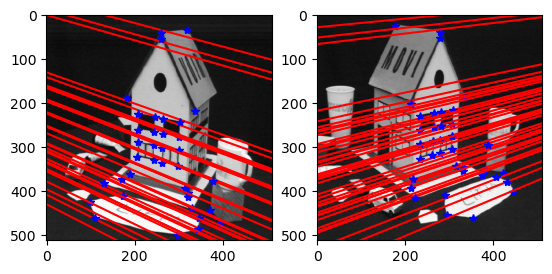

In [10]:
plt.subplot(1,2,1)
ln1 = F.T.dot(points2.T)
for i in range(ln1.shape[1]):
        plt.plot([0, im1.shape[1]], [-ln1[2][i]*1.0/ln1[1][i], -(ln1[2][i]+ln1[0][i]*im1.shape[1])*1.0/ln1[1][i]], 'r')
        plt.plot([points1[i][0]], [points1[i][1]], 'b*')
plt.imshow(im1, cmap='gray')

plt.subplot(1,2,2)
ln2 = F.dot(points1.T)
for i in range(ln2.shape[1]):
        plt.plot([0, im2.shape[1]], [-ln2[2][i]*1.0/ln2[1][i], -(ln2[2][i]+ln2[0][i]*im2.shape[1])/ln2[1][i]], 'r')
        plt.plot([points2[i][0]], [points2[i][1]], 'b*')
plt.imshow(im2, cmap='gray')

In [11]:
def compute_distance_to_epipolar_lines(points1, points2, F):
    l = F.T.dot(points2.T)
    dist_sum = 0.0
    points_num = points1.shape[0]

    for i in range(points_num):
        dist_sum += np.abs(points1[i][0]*l[0][i] + points1[i][1]*l[1][i] + l[2][i]) * 1.0 \
                    / np.sqrt(l[0][i]**2 + l[1][i]**2)
    return dist_sum / points_num

In [12]:
print("Distance entre les lignes de l'image 1 pour LLS:", compute_distance_to_epipolar_lines(points1, points2, F))


Distance entre les lignes de l'image 1 pour LLS: 28.025662937458115


In [13]:
print("Distance entre les lignes de l'image 2 pour LLS:", compute_distance_to_epipolar_lines(points2, points1, F.T))

Distance entre les lignes de l'image 2 pour LLS: 25.162875799975673


# Algorithme Normalisé des Huit Points
L'Algorithme Normalisé des Huit Points est une modification de l'Algorithme des Huit Points qui améliore la stabilité numérique et la précision de la matrice fondamentale estimée. Cela se fait en pré-traitant les données pour les rendre plus adaptées aux calculs numériques.

Voici les étapes de l'Algorithme Normalisé des Huit Points :



1. **Normalisation** :

   a. **Translation des Points vers l'Origine** : Calculer le centroïde de l'ensemble des points dans les deux images. Cela implique de trouver les coordonnées moyennes :

   $$
   \bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i \quad \text{et} \quad \bar{x'} = \frac{1}{n} \sum_{i=1}^{n} x_i'
   $$

   Ensuite, translater tous les points de sorte que les centroïdes coïncident. Cette étape garantit que le centroïde des points soit à l'origine.

  

In [14]:
N = points1.shape[0]


points1_uv = points1[:, 0:2]
points2_uv = points2[:, 0:2]

# normalization
mean1 = np.mean(points1_uv, axis=0)
mean2 = np.mean(points2_uv, axis=0)

points1_center = points1_uv - mean1
points2_center = points2_uv - mean2

 b. **Mise à l'Échelle des Points** :

   Calculer la distance moyenne des points à l'origine :

   $$
   s = \sqrt{\frac{2n}{ \sum_{i=1}^{n} ||x_i - \bar{x}||^2}}
   $$

   Mettre à l'échelle tous les points en les divisant par $s$. Cette étape assure que la distance moyenne des points à l'origine soit $\sqrt{2}$, ce qui aide à la stabilité numérique.

   Construire les matrices de transformation $T$ et $T'$ pour les opérations de translation et d'échelle, respectivement.

   $$
   T = \begin{bmatrix}
   s & 0 & -\bar{x}_1s \\
   0 & s & -\bar{x}_2s \\
   0 & 0 & 1
   \end{bmatrix}
   $$

   $$
   T' = \begin{bmatrix}
   s' & 0 & -\bar{x'}_1s' \\
   0 & s' & -\bar{x'}_2s' \\
   0 & 0 & 1
   \end{bmatrix}
   $$

In [15]:
scale1 = np.sqrt(2/(np.sum(points1_center**2)/N * 1.0))
scale2 = np.sqrt(2/(np.sum(points2_center**2)/N * 1.0))

In [16]:
T1 = np.array([[scale1, 0, -mean1[0] * scale1],
                   [0, scale1, -mean1[1] * scale1],
                   [0, 0, 1]])

T2 = np.array([[scale2, 0, -mean2[0] * scale2],
                   [0, scale2, -mean2[0] * scale2],
                   [0, 0, 1]])


2. **Construction du Système Normalisé** :

   Appliquer les transformations $T$ et $T'$ à l'ensemble initial de correspondances :

   $$
   \bar{x}_i = T x_i \quad \text{et} \quad \bar{x}_i' = T' x_i'
   $$

   Cela donne un ensemble de correspondances normalisées $\{(\bar{x}_i, \bar{x}_i')\}$.


In [17]:
q1 = T1.dot(points1.T).T; q2 = T2.dot(points2.T).T



3. **Utilisation de l'Algorithme des Huit Points** :

   Appliquer l'Algorithme des Huit Points aux correspondances normalisées pour estimer la matrice fondamentale normalisée $\bar{F}$.

In [18]:
def lls_eight_point_alg(points1, points2):
    points_num = points2.shape[0]

    W = np.zeros((points_num, 9))
    for i in range(points_num):
        u1 = points1[i][0]
        v1 = points1[i][1]
        u2 = points2[i][0]
        v2 = points2[i][1]
        W[i] = np.array([u1*u2, u2*v1, u2, v2*u1, v1*v2, v2, u1, v1, 1])

    # compute F_hat
    U, s, VT = np.linalg.svd(W, full_matrices=True)
    f = VT[-1, :]
    F_hat = np.reshape(f, (3, 3))

    # compute F
    U, s_hat, VT = np.linalg.svd(F_hat, full_matrices=True)
    s = np.zeros((3, 3))
    s[0][0] = s_hat[0]
    s[1][1] = s_hat[1]
    F = np.dot(U, np.dot(s, VT))

    return F

In [19]:
Fq = lls_eight_point_alg(q1, q2)



4. **Dénormation** :

   Après avoir obtenu la matrice fondamentale normalisée $\bar{F}$, il est nécessaire de la dénormaliser pour obtenir la véritable matrice fondamentale $F$.

   $$
   F = T'^T \bar{F} T
   $$

   Cette étape garantit que la matrice fondamentale estimée soit dans le système de coordonnées d'origine.

L'Algorithme Normalisé des Huit Points améliore considérablement la stabilité numérique du processus d'estimation et conduit à des résultats plus précis. Il est particulièrement utile lorsqu'on travaille avec des données bruitées ou mal conditionnées.

In [20]:
F_normalized = T2.T.dot(Fq).dot(T1)

In [21]:

print("Fundamental Matrix from normalized 8-point algorithm:\n", F_normalized)

Fundamental Matrix from normalized 8-point algorithm:
 [[ 6.51390476e-07 -5.33535977e-06  8.83476916e-05]
 [-4.91284473e-06 -3.40465167e-07 -6.43595884e-03]
 [-8.54797209e-04  8.84022134e-03  1.45503962e-01]]


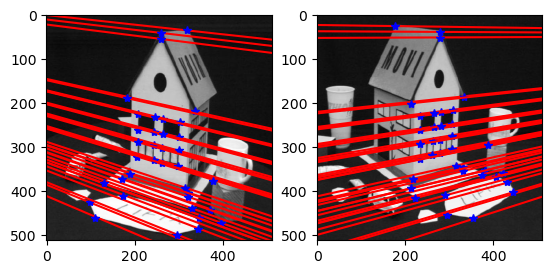

In [22]:
plt.subplot(1,2,1)
ln1 = F_normalized.T.dot(points2.T)
for i in range(ln1.shape[1]):
        plt.plot([0, im1.shape[1]], [-ln1[2][i]*1.0/ln1[1][i], -(ln1[2][i]+ln1[0][i]*im1.shape[1])*1.0/ln1[1][i]], 'r')
        plt.plot([points1[i][0]], [points1[i][1]], 'b*')
plt.imshow(im1, cmap='gray')

plt.subplot(1,2,2)
ln2 = F_normalized.dot(points1.T)
for i in range(ln2.shape[1]):
        plt.plot([0, im2.shape[1]], [-ln2[2][i]*1.0/ln2[1][i], -(ln2[2][i]+ln2[0][i]*im2.shape[1])/ln2[1][i]], 'r')
        plt.plot([points2[i][0]], [points2[i][1]], 'b*')
plt.imshow(im2, cmap='gray')